In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import librosa
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [3]:
import pickle

with open('train-wav.pkl', 'rb') as fopen:
    X = pickle.load(fopen)['X']
    
with open('test-wav.pkl', 'rb') as fopen:
    Y = pickle.load(fopen)['Y']

In [4]:
# follow hyperparameters from here, https://github.com/pytorch/fairseq/tree/master/examples/wav2vec

features = [(512, 10, 5), (512, 8, 4), (512, 4, 2), (512, 4, 2), (512, 4, 2), (512, 1, 1), (512, 1, 1)]
aggs = [(512, 2, 1), (512, 3, 1), (512, 4, 1), (512, 5, 1), (512, 6, 1), (512, 7, 1), (512, 8, 1), (512, 9, 1), 
        (512, 10, 1), (512, 11, 1), (512, 12, 1), (512, 13, 1)]
num_negatives = 10
prediction_steps = 12
learning_rate = 1e-5
min_learning_rate = 1e-9
max_learning_rate = 0.005
learning_scheduler = 'cosine'
max_update = 400000
residual_scale = 0.5
log_compression = True
warmup_updates = 50
warmup_init_lr = 1e-7
batch_size = 24
epoch = 10
total_steps = batch_size * epoch

In [5]:
# tf.compat.v1.enable_eager_execution()

In [8]:
import math
import re

def create_optimizer(loss, init_lr, num_train_steps, num_warmup_steps):
    """Creates an optimizer training op."""
    global_step = tf.train.get_or_create_global_step()
    learning_rate = tf.constant(value = init_lr, shape = [], dtype = tf.float32)
    learning_rate = tf.train.polynomial_decay(
        learning_rate,
        global_step,
        num_train_steps,
        end_learning_rate = 0.0,
        power = 1.0,
        cycle = False,
    )

    if num_warmup_steps:
        global_steps_int = tf.cast(global_step, tf.int32)
        warmup_steps_int = tf.constant(num_warmup_steps, dtype = tf.int32)

        global_steps_float = tf.cast(global_steps_int, tf.float32)
        warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

        warmup_percent_done = global_steps_float / warmup_steps_float
        warmup_learning_rate = init_lr * warmup_percent_done

        is_warmup = tf.cast(global_steps_int < warmup_steps_int, tf.float32)
        learning_rate = (
            1.0 - is_warmup
        ) * learning_rate + is_warmup * warmup_learning_rate
    
#     optimizer = tf.train.RMSPropOptimizer(learning_rate)
#     optimizer = tf.train.AdamOptimizer(learning_rate)

    optimizer = AdamWeightDecayOptimizer(
        learning_rate = learning_rate,
        weight_decay_rate = 0.01,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-6,
        exclude_from_weight_decay = ['LayerNorm', 'layer_norm', 'bias'],
    )

    tvars = tf.trainable_variables()
    grads = tf.gradients(loss, tvars)

    # This is how the model was pre-trained.
    # (grads, _) = tf.clip_by_global_norm(grads, clip_norm = 1.0)

    train_op = optimizer.apply_gradients(
        zip(grads, tvars), global_step = global_step
    )

    new_global_step = global_step + 1
    train_op = tf.group(train_op, [global_step.assign(new_global_step)])
    return train_op


class AdamWeightDecayOptimizer(tf.train.Optimizer):
    """A basic Adam optimizer that includes "correct" L2 weight decay."""

    def __init__(
        self,
        learning_rate,
        weight_decay_rate = 0.0,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-6,
        exclude_from_weight_decay = None,
        name = 'AdamWeightDecayOptimizer',
    ):
        """Constructs a AdamWeightDecayOptimizer."""
        super(AdamWeightDecayOptimizer, self).__init__(False, name)

        self.learning_rate = learning_rate
        self.weight_decay_rate = weight_decay_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.exclude_from_weight_decay = exclude_from_weight_decay

    def apply_gradients(self, grads_and_vars, global_step = None, name = None):
        """See base class."""
        assignments = []
        for (grad, param) in grads_and_vars:
            if grad is None or param is None:
                continue

            param_name = self._get_variable_name(param.name)

            m = tf.get_variable(
                name = param_name + '/adam_m',
                shape = param.shape.as_list(),
                dtype = tf.float32,
                trainable = False,
                initializer = tf.zeros_initializer(),
            )
            v = tf.get_variable(
                name = param_name + '/adam_v',
                shape = param.shape.as_list(),
                dtype = tf.float32,
                trainable = False,
                initializer = tf.zeros_initializer(),
            )
            next_m = tf.multiply(self.beta_1, m) + tf.multiply(
                1.0 - self.beta_1, grad
            )
            next_v = tf.multiply(self.beta_2, v) + tf.multiply(
                1.0 - self.beta_2, tf.square(grad)
            )

            update = next_m / (tf.sqrt(next_v) + self.epsilon)
            if self._do_use_weight_decay(param_name):
                update += self.weight_decay_rate * param

            update_with_lr = self.learning_rate * update

            next_param = param - update_with_lr

            assignments.extend(
                [param.assign(next_param), m.assign(next_m), v.assign(next_v)]
            )
        return tf.group(*assignments, name = name)

    def _do_use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay_rate:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _get_variable_name(self, param_name):
        """Get the variable name from the tensor name."""
        m = re.match('^(.*):\\d+$', param_name)
        if m is not None:
            param_name = m.group(1)
        return param_name

def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
      (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def layer_norm(input_tensor, name=None):
    return tf.contrib.layers.layer_norm(
      inputs=input_tensor, begin_norm_axis=1, begin_params_axis=-1, scope=name)


def cnn_block(x, hidden_dim, kernel_size, strides):
    x =  tf.layers.conv1d(inputs = x,
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          strides = strides)
    
    x = layer_norm(x)
    # x = gelu(x)
    x = tf.nn.relu6(x)
    return x

def cnn_aggregator(x, hidden_dim, kernel_size, strides):
    ka = kernel_size // 2
    kb = ka - 1 if kernel_size % 2 == 0 else ka
    pad = tf.zeros([tf.shape(x)[0], kb + ka, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          strides = strides)
    
    x = layer_norm(x)
    # x = gelu(x)
    x = tf.nn.relu6(x)
    return x

def negative_sample(y):
    bsz = tf.shape(y)[0]
    fsz = tf.shape(y)[1]
    tsz = tf.shape(y)[2]
    
    # b, d, t -> d, b, t
    y = tf.transpose(y, [1, 0, 2])
    y = tf.reshape(y, (fsz, -1))
    neg_idxs = tf.random_uniform((bsz, num_negatives * tsz), minval=0, maxval=tsz, dtype=tf.int32)
    
    ranged = tf.expand_dims(tf.range(1, bsz), axis = 1)
    a = tf.add(neg_idxs[1:bsz], tf.tile(ranged, [1, num_negatives * tsz]) * tsz)
    
    neg_idxs = tf.concat([neg_idxs[:1], a, neg_idxs[bsz:]], axis = 0)
    neg_idxs = tf.reshape(neg_idxs, [-1])
    negs = tf.gather(y, neg_idxs, axis=1)
    negs = tf.reshape(negs, (fsz, bsz, num_negatives, tsz))
    negs = tf.transpose(negs, [2, 1, 0, 3])
    return negs

class Model:
    def __init__(self):
        self.X = tf.placeholder(tf.float32, (None, None))
        feature = tf.expand_dims(self.X, axis = 2)
        
        for no, f in enumerate(features):
            size_layers = f[0]
            kernel_size = f[1]
            strides = f[2]
            with tf.variable_scope('feature_%d'%no):
                feature = cnn_block(feature, size_layers, kernel_size, strides)
        
        if log_compression:
            feature = tf.math.abs(feature)
            feature = feature + 1
            feature = tf.math.log(feature)
        
        x = tf.identity(feature)
        self.targets = tf.identity(feature)
        for no, f in enumerate(aggs):
            size_layers = f[0]
            kernel_size = f[1]
            strides = f[2]
            with tf.variable_scope('agg_%d'%no):
                x = cnn_aggregator(x, size_layers, kernel_size, strides)
                
        jin = 0
        rin = 0
        for _, k, stride in features:
            if rin == 0:
                rin = k
            rin = rin + (k - 1) * jin
            if jin == 0:
                jin = stride
            else:
                jin *= stride
        offset = math.ceil(rin / jin)

        offset = int(offset)
        
        self.logits = x
        transpose_targets = tf.transpose(self.targets, (0, 2, 1))
        self.negatives = negative_sample(transpose_targets)
        
        y = tf.expand_dims(transpose_targets, axis = 0)
        targets = tf.concat([y, self.negatives], axis = 0)
        b = tf.shape(targets)[0]

        x = tf.expand_dims(tf.transpose(self.logits, (0, 2, 1)), axis = -1)
        x = tf.layers.conv2d_transpose(x, prediction_steps, (1, 1))
        x = tf.expand_dims(x, axis = 0) 
        x = tf.tile(x, [b, 1, 1, 1, 1])
        
        copies = tf.shape(x)[0]
        bsz = tf.shape(x)[1]
        dim = tf.shape(x)[2]
        tsz = tf.shape(x)[3]
        steps = tf.shape(x)[4]
        
        steps = tf.math.minimum(steps, tsz - offset)
        predictions = tf.zeros(bsz * copies * (tsz - offset + 1) * \
                               steps - ((steps + 1) * steps // 2) * copies * bsz)
        labels = tf.zeros_like(predictions)
        
        def body(i, start, end, predictions, labels, offset):
            offset = i + offset
            end = start + (tsz - offset) * bsz * copies
            pos_num = (end - start) // copies
            s = tf.reduce_sum((x[:, :, :, :-offset, i] * targets[:, :, :, offset:]), axis = 2)
            s = tf.reshape(s, [-1])
            s = tf.pad(s, [[start, tf.shape(predictions)[0] - (start + tf.shape(s)[0])]])
            predictions = tf.add(predictions, s)
            pos_num = tf.cond(pos_num > 0, lambda: pos_num, lambda: 0)
            l = tf.ones((pos_num))
            l = tf.pad(l, [[start, tf.shape(labels)[0] - (start + pos_num)]])
            labels = tf.add(labels, l)
            return i + 1, end, end, predictions, labels, offset

        def condition(i, start, end, predictions, labels, offset):
            return i < steps

        ranged = tf.Variable(tf.constant(0))
        _, _, _, predictions, labels, _ = tf.while_loop(condition, body, [0, 0, 0, predictions, labels, offset])
        self.predictions = predictions
        self.labels = labels
        
        label_weights = tf.abs(tf.sign(self.predictions))
        
        numerator = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=self.labels,
            logits=self.predictions) * label_weights
        numerator = tf.reduce_sum(numerator)
        denominator = tf.reduce_sum(label_weights) + 1e-5
        self.cost = numerator / denominator
        print(self.cost)
        self.optimizer = create_optimizer(self.cost, learning_rate, total_steps, warmup_updates)

In [9]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model()
sess.run(tf.global_variables_initializer())

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Tensor("truediv:0", shape=(), dtype=float32)
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [10]:
batch_x = X[:1]
logits, targets, neg = sess.run([model.logits, model.targets, model.negatives], feed_dict = {model.X: batch_x})
logits.shape, targets.shape

((1, 161, 512), (1, 161, 512))

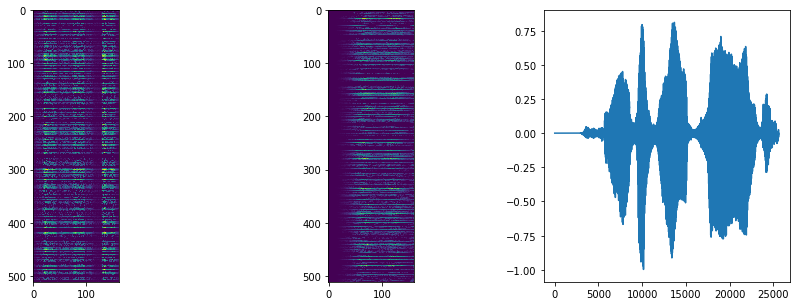

In [11]:
plt.figure(figsize = (15, 5))

plt.subplot(1,3,1)
plt.imshow(targets[0].T)
plt.subplot(1,3,2)
plt.imshow(logits[0].T)
plt.subplot(1,3,3)
plt.plot(X[-2])

In [12]:
import IPython.display as ipd

ipd.Audio(X[0], rate = 16000)

minibatch loop: 100%|██████████| 681/681 [13:05<00:00,  1.15s/it, cost=0.539]


epoch 1, training avg cost 0.607221


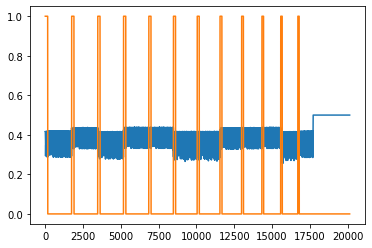

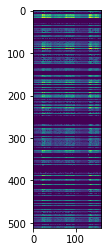

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.539]


epoch 2, training avg cost 0.538868


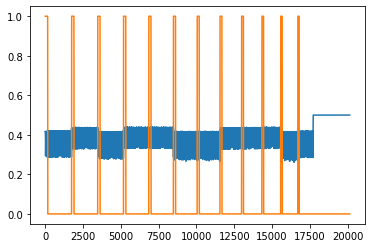

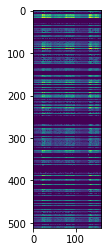

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.54] 


epoch 3, training avg cost 0.538869


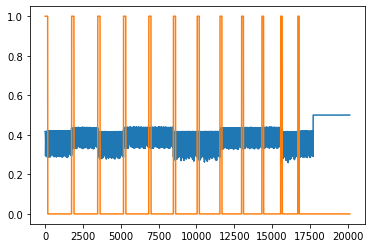

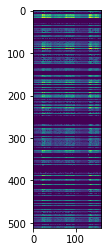

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.54] 


epoch 4, training avg cost 0.538858


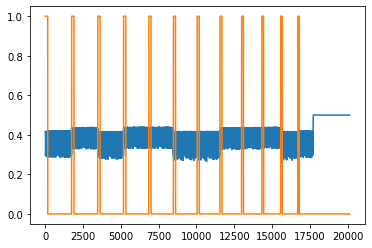

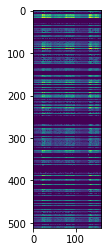

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.539]


epoch 5, training avg cost 0.538868


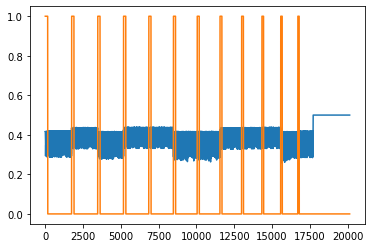

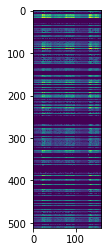

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.54] 


epoch 6, training avg cost 0.538846


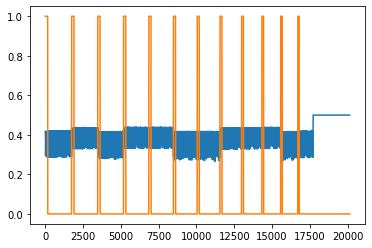

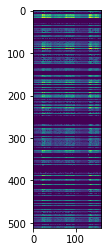

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.54] 


epoch 7, training avg cost 0.538854


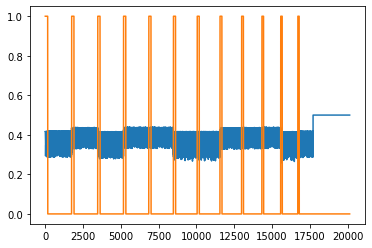

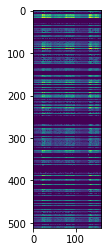

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.539]


epoch 8, training avg cost 0.538862


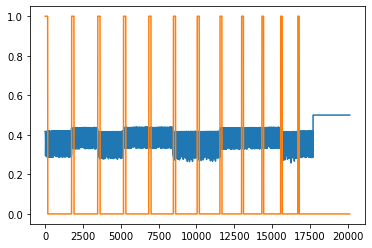

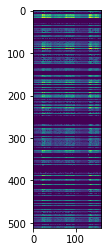

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.539]


epoch 9, training avg cost 0.538872


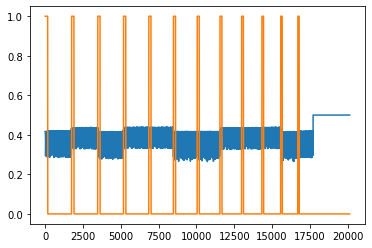

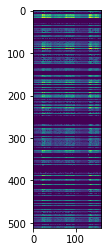

minibatch loop: 100%|██████████| 681/681 [05:42<00:00,  1.99it/s, cost=0.54] 


epoch 10, training avg cost 0.538868


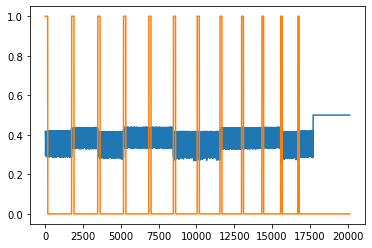

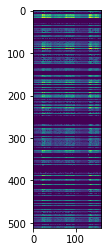

In [13]:
from tqdm import tqdm
import time

LOSS = []
maxlen = 50000

for count in range(epoch):
    pbar = tqdm(
        range(0, len(X), batch_size), desc = 'minibatch loop')
    train_cost = []
    for i in pbar:
        batch_x = X[i : min(i + batch_size, len(X))]
        batch_x = tf.keras.preprocessing.sequence.pad_sequences(
            batch_x, dtype = 'float32', padding = 'post'
        )[:, :maxlen]
        while True:
            try:
                _, cost = sess.run(
                    [model.optimizer, model.cost],
                    feed_dict = {model.X: batch_x},
                )
                break
            except Exception as e:
                print(e)
                time.sleep(1)
        train_cost.append(cost)
        pbar.set_postfix(cost = cost)
    train_cost = np.mean(train_cost)
    LOSS.append(train_cost)
    print('epoch %d, training avg cost %f'%(count + 1, train_cost))
    
    p, l, t = sess.run([tf.nn.sigmoid(model.predictions), model.labels, model.targets], feed_dict = {model.X: X[:1]})
    plt.plot(p)
    plt.plot(l)
    plt.show()
    
    plt.imshow(t[0].T)
    plt.show()

In [ ]:
batch_x = X[-2:]
batch_x = tf.keras.preprocessing.sequence.pad_sequences(
    batch_x, dtype = 'float32', padding = 'post'
)
logits, targets, neg = sess.run([model.logits, model.targets, model.negatives], feed_dict = {model.X: batch_x})
logits.shape, targets.shape

In [ ]:
plt.figure(figsize = (15, 5))

plt.subplot(1,3,1)
plt.imshow(targets[0].T)
plt.subplot(1,3,2)
plt.imshow(logits[0].T)
plt.subplot(1,3,3)
plt.plot(X[-2])

In [ ]:
p, l = sess.run([tf.nn.sigmoid(model.predictions), model.labels], feed_dict = {model.X: X[:1]})
plt.plot(p)
plt.plot(l)
plt.show()

In [ ]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'wav2vec/model.ckpt')